<div align="center">
  <img src="Images/image2.jpg" alt="Logo" width="500">
  <h1 style="font-size: 40px; text-decoration: underline;">TRASH IMAGE CLASSIFICATION</h1>
</div>


### DATA AUGMENTATION AND MODELING

### Splitting the data

In [19]:
import splitfolders
input_folder = 'RealWaste'
splitfolders.ratio(input_folder,output = 'RealWaste2',seed = 42,ratio = (.7,.2,.1),group_prefix=None)



Copying files: 4291 files [00:15, 269.80 files/s]


Observations

Training Set Size:
Largest Class: Plastic with 644 images.
Smallest Class: Textile Trash with 222 images.

Validation Set Size:
Largest Class: Glass with 84 images.
Smallest Class: Textile Trash with 63 images.

Test Set Size:
Largest Class: Plastic with 93 images.
Smallest Class: Textile Trash with 33 images.


### Data Augmentation

In [21]:
#train data generator
train_dir = ImageDataGenerator(
         rescale=1./255,
        rotation_range=45,     
        width_shift_range=0.2,   
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

train_generator = train_dir.flow_from_directory(
    'RealWaste2/train',
    target_size=(524, 524),
    batch_size=32,
    class_mode='categorical'
)
#Val data generator
val_dir = ImageDataGenerator(rescale = 1./255)
validation_generator = val_dir.flow_from_directory(
    'RealWaste2/val',
    target_size=(524, 524),
    batch_size=32,
    class_mode='categorical'
)
#Test Data Generator
test_dir = ImageDataGenerator(rescale=1./255)
test_generator = test_dir.flow_from_directory(
    'RealWaste2/test',
    target_size=(524, 524),
    batch_size=32,
    class_mode='categorical'
)

Found 3001 images belonging to 8 classes.
Found 857 images belonging to 8 classes.
Found 433 images belonging to 8 classes.


In [22]:
train_images, train_labels = next(train_generator)
print(train_images.shape)
print(train_labels.shape)

(32, 524, 524, 3)
(32, 8)


In [23]:
test_images, test_labels = next(test_generator)
print(test_images.shape)
print(test_labels.shape)

(32, 524, 524, 3)
(32, 8)


In [24]:
val_images, val_labels = next(validation_generator)
print(val_images.shape)
print(val_labels.shape)

(32, 524, 524, 3)
(32, 8)


The original image serves as a baseline, while the augmented images show various transformations applied. This includes rotations, shifts, shears, and zooms. The augmentations introduced significant variations, demonstrating how the data augmentation techniques can enrich the dataset by creating different views of the same image.

### Building A CNN Model to Classify the Images 

Landfills contain a wide range of waste materials, and accurately categorizing them is essential for effective waste management. By leveraging CNNs, the classification process can be automated, significantly improving the efficiency and accuracy of waste diversion strategies such as recycling, composting, and proper disposal. CNNs excel at image analysis and feature extraction, allowing them to capture intricate details and patterns from the waste images in the dataset. The convolutional layers in CNNs are able to identify edges, textures, and other relevant characteristics, enabling the network to learn and leverage these features for accurate waste classification. Pooling layers nested throughout the architecture down-sample produced feature maps, allowing models to generalize object specific characteristics into differing contexts. 



### Inception V3 CNN Model

Due to the suboptimal performance of our baseline models with custom convolution layers, which failed to meet our predefined success thresholds, we opted to utilize pre-trained architectures. We chose Inception V3 for the following reasons:

1. **Proven Performance**: Demonstrated high accuracy across various image classification tasks.
2. **Pre-trained Weights**: Benefits from extensive prior training on the ImageNet dataset.
3. **Inception Modules**: Simultaneous multiple convolutional operations enhance feature capture.
4. **Computational Efficiency**: Balances computational cost and accuracy effectively.
5. **Scalability and Flexibility**: Easily fine-tuned and adapted for our specific dataset and requirements.



In [38]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [39]:


class InceptionV3Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        # Load the InceptionV3 model pre-trained on ImageNet
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)  # 8 categories for classification

        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, train_dir, val_dir, batch_size=32, epochs=10):
        # Define image size and batch size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generators with reduced image size
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr]
        )

    def evaluate_model(self, test_dir, batch_size=32):
        # Define image size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generator
        test_datagen = ImageDataGenerator(rescale=1./255)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model saved to {file_path}")

    def plot_training_history(self):
        if self.history:
            plt.figure(figsize=(12, 6))

            # Plot training & validation accuracy values
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['accuracy'])
            plt.plot(self.history.history['val_accuracy'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            # Plot training & validation loss values
            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.tight_layout()
            plt.show()
        else:
            print("No training history found. Please train the model first.")


In [40]:
# Instantiate the model
inception_model = InceptionV3Model()

# Build the model
inception_model.build_model()

# Define directories
train_dir = 'RealWaste2/train'
val_dir = 'RealWaste2/val'
test_dir = 'RealWaste2/test'

In [41]:
# Train the model
inception_model.train_model(train_dir, val_dir, batch_size=32, epochs=10)

Found 3001 images belonging to 8 classes.
Found 857 images belonging to 8 classes.
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.2494 - loss: 2.2943 - val_accuracy: 0.6441 - val_loss: 1.1271 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.5108 - loss: 1.3434 - val_accuracy: 0.6639 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5841 - loss: 1.1524 - val_accuracy: 0.6826 - val_loss: 0.8570 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.6183 - loss: 1.0890 - val_accuracy: 0.7141 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.6665 - loss: 0.9635 - val_accuracy: 0.7083 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.6703 - loss: 0.9744 - val_accuracy: 0.7340 - val_loss: 0.7470 - learning_rate: 0.0010
Epoch 7/10


In [42]:
# Evaluate the model
inception_model.evaluate_model(test_dir, batch_size=32)

Found 433 images belonging to 8 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7150 - loss: 0.7252
Test Accuracy: 0.74


(0.7187150716781616, 0.7436489462852478)

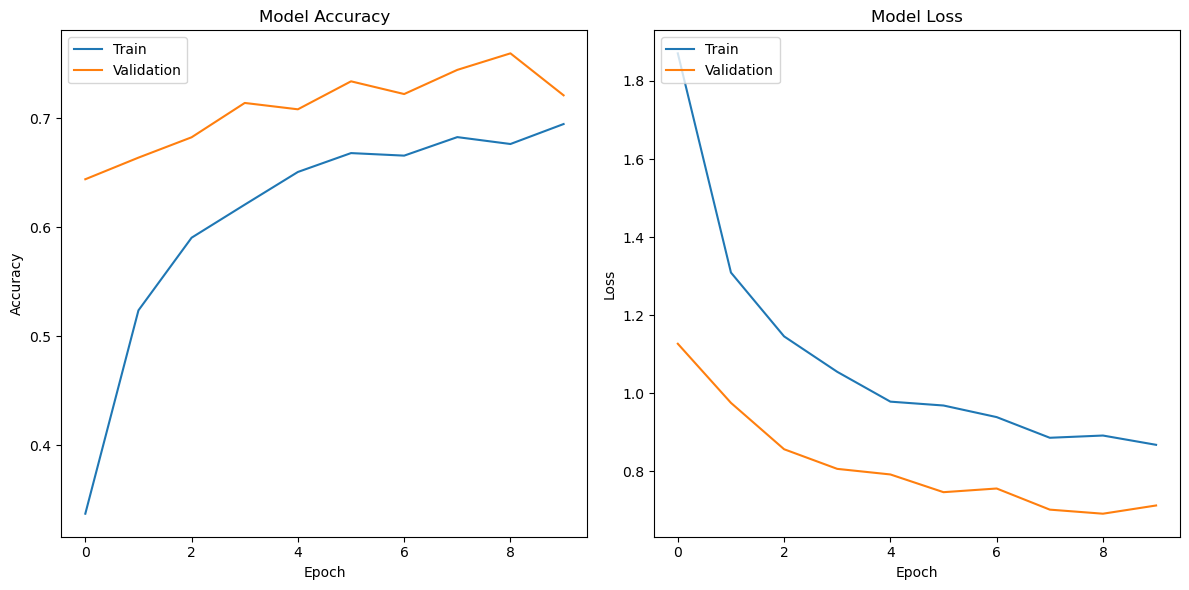

In [43]:
# Plot the training history
inception_model.plot_training_history()

In [44]:
# Save the model
inception_model.save_model('waste_classification_inception_model.h5')

Model saved to waste_classification_inception_model.h5


In [61]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Load the trained model
model = load_model('waste_classification_inception_model.h5')

# Define image size and batch size
IMAGE_SIZE = (224, 224)

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = 'RealWaste2/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


Found 433 images belonging to 8 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step
Weighted F1 Score: 0.74
                     precision    recall  f1-score   support

      Food Organics       0.86      0.74      0.79        42
              Glass       0.80      0.76      0.78        42
              Metal       0.77      0.73      0.75        79
Miscellaneous Trash       0.50      0.46      0.48        50
              Paper       0.91      0.78      0.84        50
            Plastic       0.72      0.82      0.76        93
      Textile Trash       0.61      0.76      0.68        33
         Vegetation       0.83      0.86      0.84        44

           accuracy                           0.74       433
          macro avg       0.75      0.74      0.74       433
       weighted avg       0.75      0.74      0.74       433



### Observations
The InceptionV3 model, using transfer learning, provided a substantial improvement over the custom baseline and augmented CNN models. The higher accuracy and lower loss metrics indicate better performance in classifying waste categories in the RealWaste dataset. The advanced architecture of InceptionV3, combined with its pre-trained weights, enabled more efficient feature extraction and improved model performance, making it a more suitable choice for the waste classification task.

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

class DenseNet121Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        # Load the DenseNet121 model pre-trained on ImageNet
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)  # 8 categories for classification

        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def fine_tune_model(self, fine_tune_at):
        # Unfreeze the top layers of the model
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in self.model.layers[fine_tune_at:]:
            layer.trainable = True

        # Compile the model with a lower learning rate for fine-tuning
        self.model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, train_dir, val_dir, batch_size=32, epochs=20):
        # Define image size and batch size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generators with reduced image size
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)
        lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr, lr_scheduler]
        )

    def evaluate_model(self, test_dir, batch_size=32):
        # Define image size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generator
        test_datagen = ImageDataGenerator(rescale=1./255)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model saved to {file_path}")

    def plot_training_history(self):
        if self.history:
            plt.figure(figsize=(12, 6))

            # Plot training & validation accuracy values
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['accuracy'])
            plt.plot(self.history.history['val_accuracy'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            # Plot training & validation loss values
            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.tight_layout()
            plt.show()
        else:
            print("No training history found. Please train the model first.")


In [55]:
# Instantiate the model
densenet_model = DenseNet121Model()

# Build the model
densenet_model.build_model()

# Define directories
train_dir = 'RealWaste2/train'
val_dir = 'RealWaste2/val'
test_dir = 'RealWaste2/test'

In [56]:
# Train the model
densenet_model.train_model(train_dir, val_dir, batch_size=32, epochs=10)

Found 3001 images belonging to 8 classes.
Found 857 images belonging to 8 classes.
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.3127 - loss: 2.0209 - val_accuracy: 0.6056 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.5737 - loss: 1.1610 - val_accuracy: 0.7281 - val_loss: 0.7555 - learning_rate: 8.9125e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.6476 - loss: 0.9636 - val_accuracy: 0.7585 - val_loss: 0.6742 - learning_rate: 7.9433e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.6719 - loss: 0.8944 - val_accuracy: 0.7620 - val_loss: 0.6513 - learning_rate: 7.0795e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.7218 - loss: 0.7913 - val_accuracy: 0.7433 - val_loss: 0.6833 - learning_rate: 6.3096e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.7433 - loss: 0.7284 - val_accuracy: 0.7760 - val_loss: 0.6326 - learning_rate: 5.

In [58]:
# Evaluate the model
densenet_model.evaluate_model(test_dir, batch_size=32)

Found 433 images belonging to 8 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7543 - loss: 0.6930
Test Accuracy: 0.79


(0.6264948844909668, 0.7875288724899292)

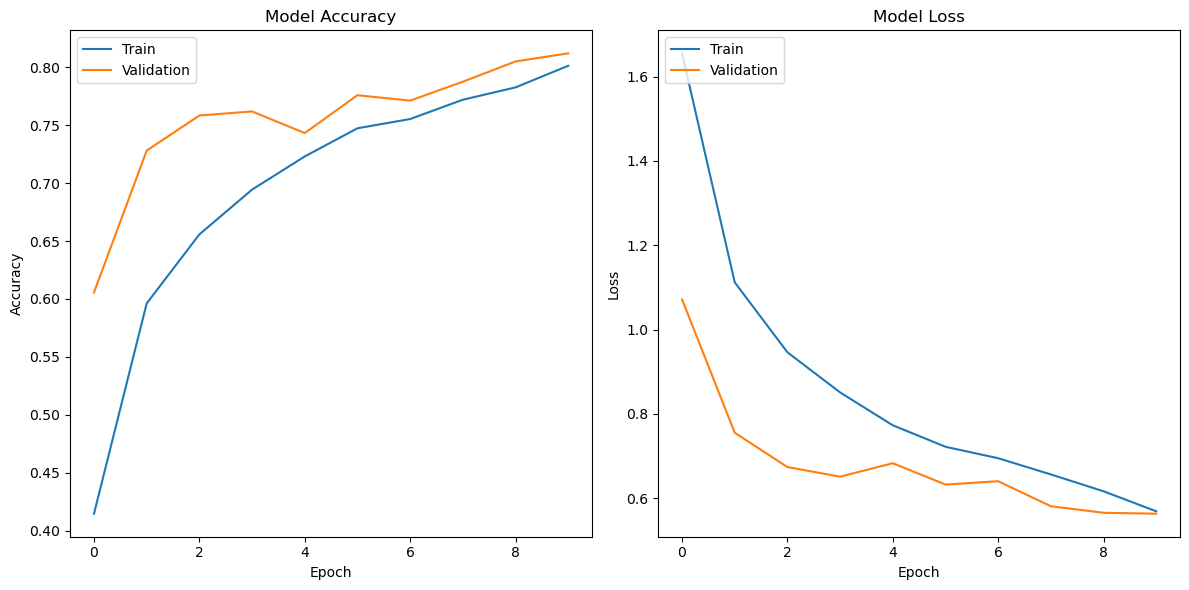

In [59]:
# Plot the training history
densenet_model.plot_training_history()

In [60]:
# Save the model
densenet_model.save_model('waste_classification_densenet_model.h5')

Model saved to waste_classification_densenet_model.h5


In [62]:
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('waste_classification_densenet_model.h5')

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = 'RealWaste2/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


Found 433 images belonging to 8 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step
Weighted F1 Score: 0.78
                     precision    recall  f1-score   support

      Food Organics       0.84      0.90      0.87        42
              Glass       0.60      0.69      0.64        42
              Metal       0.75      0.90      0.82        79
Miscellaneous Trash       0.72      0.46      0.56        50
              Paper       0.86      0.96      0.91        50
            Plastic       0.81      0.76      0.78        93
      Textile Trash       0.87      0.79      0.83        33
         Vegetation       0.90      0.80      0.84        44

           accuracy                           0.79       433
          macro avg       0.79      0.78      0.78       433
       weighted avg       0.79      0.79      0.78       433



### DenseNet121 Model Performance
- **Test Accuracy**: 0.79
- **Weighted F1 Score**: 0.78
- **Training and Validation**: The DenseNet121 model demonstrated stable convergence and improved accuracy over the training epochs. The model's regularization techniques, such as dropout layers, contributed to its robustness and ability to generalize well to the test data.


While both the DenseNet121 and Inception V3 models significantly outperformed the baseline custom convolutional models, the DenseNet121 model demonstrated superior performance in terms of both test accuracy and weighted F1 score. The DenseNet121 model however falls short of our target 80% accuracy threshold and exhibits class imbalance in minority classes, which leads us to try out more effecient architectures.
